# Discovering Binding Sites on a Viral Genome with SMEAGOL

This notebook demonstrates the functions for binding site discovery and enrichment. Here we use the genome of the Lymphocytic choriomeningitis mammarenavirus as an example.

## Import requirements

In [1]:
# General imports
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Find SMEAGOL
import sys
sys.path.append('../../SMEAGOL')

# Custom imports
from smeagol.utils import shuffle_records
from smeagol.enrich import *
from smeagol.visualization import plot_pwm, plot_binned_count_dist, plot_background
from smeagol.models import PWMModel 
from smeagol.encoding import MultiSeqEncoding
from smeagol.fastaio import *
from smeagol.inference import find_sites_multiseq

Using TensorFlow backend.


## Load and explore PWMs filtered from Attract DB

Below, we provide the path to the file containing PWMs filtered from Attract DB.

In [2]:
pwm_file = '../VirusHostInteractionAtlas/DATA/PWMs/ATtRACT/attract_filtered.h5'

We read PWMs from this file:

In [3]:
%%time
pwms = pd.read_hdf(pwm_file, key="data")
pwms.head()

CPU times: user 37.8 ms, sys: 9.74 ms, total: 47.5 ms
Wall time: 64.8 ms


,Matrix_id,Gene_name,Gene_id,Experiment_description,weight
0,s36,HNRNPDL,ENSG00000152795,SELEX,"[[1.7558705993328931, -8.3487281542314, -0.697..."
1,M269_0.6,ZFP36,ENSG00000128016,SELEX,"[[1.956056652412403, -4.643856189774724, -4.64..."
2,M157_0.6,CELF5,ENSG00000161082,RNAcompete,"[[-1.5740884983277694, -1.5740884983277694, -1..."
3,M042_0.6,PABPC4,ENSG00000090621,RNAcompete,"[[1.6386523770814128, -1.278165447983456, -1.1..."
4,M062_0.6,SART3,ENSG00000075856,RNAcompete,"[[1.5984037218569163, -1.6260542637885405, -1...."


The `pwms` dataframe contains all the PWMs filtered from Attract. The column `Matrix_id` gives a unique ID for each PWM, and the column `Gene_name` gives the name of the RBP. We can see how many PWMs are in our list:

In [4]:
len(pwms)

197

We have multiple PWMs for some RBPs. To see how many distinct RBPs are in the list:

In [5]:
len(pd.unique(pwms.Gene_name))

99

We can select a particular PWM using its `Matrix_id`:

In [6]:
pwms[pwms.Matrix_id=='s36']

,Matrix_id,Gene_name,Gene_id,Experiment_description,weight
0,s36,HNRNPDL,ENSG00000152795,SELEX,"[[1.7558705993328931, -8.3487281542314, -0.697..."


We can also select all PWMs for an RBP:

In [7]:
pwms[pwms.Gene_name=='HNRNPDL']

,Matrix_id,Gene_name,Gene_id,Experiment_description,weight
0,s36,HNRNPDL,ENSG00000152795,SELEX,"[[1.7558705993328931, -8.3487281542314, -0.697..."
89,s44,HNRNPDL,ENSG00000152795,SELEX,"[[1.2563397532592488, -6.977279923497724, 0.67..."
158,s35,HNRNPDL,ENSG00000152795,SELEX,"[[0.9857861407812133, -5.672425341972592, -5.6..."
179,s43,HNRNPDL,ENSG00000152795,SELEX,"[[0.0, -1.57540819400737, 1.412038755649923, -..."


We can plot any PWM in `pwms` as follows:

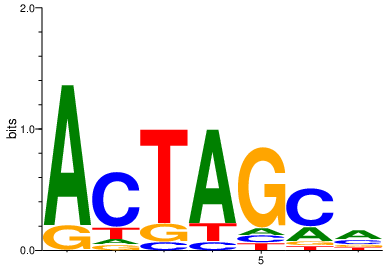

In [8]:
plot_pwm(pwms, Matrix_id='s36')

Finally, we encode all these PWMs as a convolutional model. This will allow us to scan genome sequence(s).

In [9]:
model = PWMModel(pwms)

## Load the genome

Below we provide the path to the fasta file containing the genome sequence to be analyzed.

In [10]:
#genome_file = '../VirusHostInteractionAtlas/DATA/Genomes/Genomes/IV/Monopartite/Coronaviridae/GCF_009858895.2/GCF_009858895.2_ASM985889v3_genomic.fna.gz'
genome_file = '../VirusHostInteractionAtlas/DATA/Genomes/Genomes/V/Segmented/Orthomyxoviridae/GCF_000820495.2/GCF_000820495.2_ViralMultiSegProj14656_genomic.fna.gz'

We need to specify whether this is a `+` or `-` sense viral genome.

In [11]:
genome_sense = '+'

We now read the genome sequence:

In [12]:
%%time
genome = read_fasta(genome_file)

Read 8 records from ../VirusHostInteractionAtlas/DATA/Genomes/Genomes/V/Segmented/Orthomyxoviridae/GCF_000820495.2/GCF_000820495.2_ViralMultiSegProj14656_genomic.fna.gz
CPU times: user 11 ms, sys: 4.89 ms, total: 15.9 ms
Wall time: 28 ms


The genome sequence is stored in an object called `genome`.

In [13]:
genome

[SeqRecord(seq=Seq('AGCAGAAGCGGAGCTTTAAGATGAATATAAATCCATATTTTCTTTTCATAGATG...ACT'), id='NC_002204.1', name='NC_002204.1', description='NC_002204.1 Influenza B virus RNA 1, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGACGTTGGCTAAAATTGAACTACTAAAGCAGCTGTTAAGGGACAATGAAGCC...TAA'), id='NC_002205.1', name='NC_002205.1', description='NC_002205.1 Influenza B virus (B/Lee/1940) segment 2, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATACTTTTATTACAAAGAATTTCCAGACTACAATAATACAAAAGGCCAAA...TTT'), id='NC_002206.1', name='NC_002206.1', description='NC_002206.1 Influenza B virus (B/Lee/1940) segment 3, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('AGCAGAAGCGTTGCATTTTCTAATATCCACAAAATGAAGGCAATAATTGTACTA...ACT'), id='NC_002207.1', name='NC_002207.1', description='NC_002207.1 Influenza B virus (B/Lee/1940) segment 4, complete sequence', dbxrefs=[]),
 SeqRecord(seq=Seq('GGCAGAAGCACAGCATTTTCTTGTGAGCTTCGAGCACTAATAAAACTGAAAATC...ACT'), id='NC_002208.1', name='NC_002208.1', descrip

In [14]:
genome_len = sum([len(x) for x in genome])
genome_len

14452

## Number of binding sites found at various thresholds

We generate a background distribution by shuffling the genome sequence multiple times. We need to specify two parameters:

We begin by demonstrating how to get the distribution of number of binding sites by score. We begin by selecting a preliminary, low threshold of 0.4. In the process, we can also choose whether to encode and scan the reverse complement sequence. To encode and scan the reverse complement sequence as well as the given sequence, we specify `rcomp=True`.

In [15]:
simN=300 # Number of times to shuffle
simK=2 # k-mer length to keep fixed
rcomp=False

In [16]:
threshold_binned_results = examine_thresholds(genome, model, simN, simK, rcomp, sense=genome_sense, 
                                              min_threshold=0.4, verbose=True, combine_seqs=True)

Shuffled 8 input sequence(s) 300 times while conserving k-mer frequency for k = 2



We can view the first few sequences:

In [17]:
threshold_binned_results['shuf_genome'][:3]

[SeqRecord(seq=Seq('AGATCAACTTGCCGTTGGAAAGAATGTGACTGCACAAAGCCCCTCAAAAACAGC...CCT'), id='background_seq_1', name='NC_002204.1', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('AGAGGCAGATTCTAGATGTAGAATAAGCCACACAAATGGGACAAAAAAATAAAA...CTT'), id='background_seq_2', name='NC_002204.1', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('AGGCAATACACCATCAAGCGGGTATGAAGCCATAAAGTTTGGCAGGCCACATCA...ACT'), id='background_seq_3', name='NC_002204.1', description='<unknown description>', dbxrefs=[])]

`real_binned` now contains the number of binding sites found for each PWM, binned by score. We can view the first few entries:

In [18]:
threshold_binned_results['real_binned'].head()

,Matrix_id,sense,bin,num
0,126,+,0.4,0
1,126,+,0.5,5
2,126,+,0.6,0
3,126,+,0.7,0
4,126,+,0.8,0


The `num` column records the number of binding sites per PWM, per bin.

We plot the distribution of binding sites on the real genome for a given PWM. Here, we are plotting the distribution of binding sites only on the `+` sense strand.

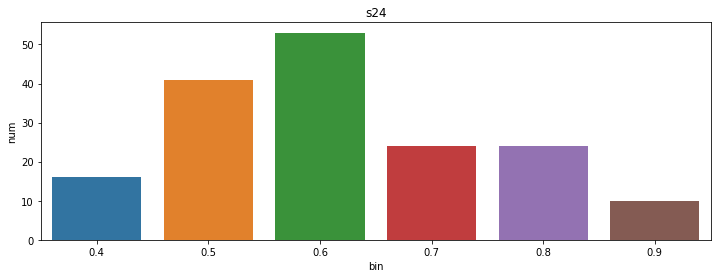

In [19]:
plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='s24', sense ='+')

We will now scan the shuffled genome sequences for binding sites, and count the number of sites per bin. This can take a long time!

In [20]:
threshold_binned_results['shuf_binned'].head()

,Matrix_id,sense,bin,id,num
0,126,+,0.4,background_seq_1,0
1,126,+,0.4,background_seq_10,0
2,126,+,0.4,background_seq_100,0
3,126,+,0.4,background_seq_101,0
4,126,+,0.4,background_seq_102,0


We can now plot the distribution of binding sites per bin for the real and shuffled genome sequences, for any given PWM.

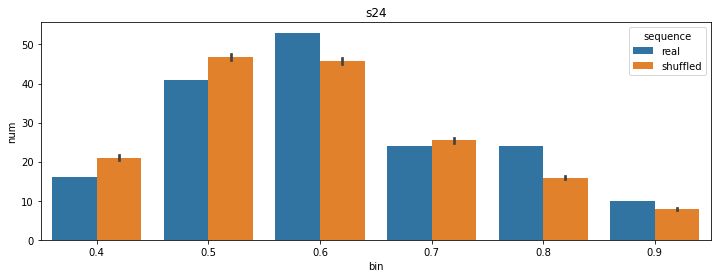

In [21]:
plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='s24', sense ='+', 
                       shuf_preds=threshold_binned_results['shuf_binned'])

### Binding site discovery and enrichment for a specified threshold

Based on this exploration, we can select a higher threshold to identify binding sites, and test for enrichment using a simple function.

In [22]:
simN=300
simK=2
rcomp=True
threshold=0.8

In [23]:
%%time
enrichment_result = enrich_in_genome(genome, model, simN=simN, simK=simK, rcomp=rcomp, genome_sense=genome_sense, 
                                     threshold=threshold, verbose=True, combine_seqs=True, background='binomial')

Shuffled 8 input sequence(s) 300 times while conserving k-mer frequency for k = 2
CPU times: user 37.5 s, sys: 7.71 s, total: 45.2 s
Wall time: 36.4 s


In [24]:
enrichment_result.keys()

dict_keys(['enrichment', 'real_sites', 'real_counts', 'shuf_stats', 'shuf_counts', 'shuf_genome'])

We can view the locations of the binding sites:

In [25]:
real_sites = enrichment_result['real_sites']
real_sites.head()

,id,name,sense,start,Matrix_id,width,end,score,max_score,frac_score
0,NC_002204.1,NC_002204.1,+,8,s42,6,14,5.967936,7.328249,0.814374
1,NC_002204.1,NC_002204.1,+,15,s1,5,20,6.947326,7.529893,0.922633
2,NC_002204.1,NC_002204.1,+,15,s6,5,20,6.947325,7.529893,0.922633
3,NC_002204.1,NC_002204.1,+,15,s9,5,20,7.148956,7.148956,1.000000
4,NC_002204.1,NC_002204.1,+,25,75,6,31,5.997296,5.997296,1.000000


And the number of binding sites per PWM in the real genome:

In [26]:
real_counts = enrichment_result['real_counts']
real_counts.head()

,Matrix_id,sense,num
0,126,+,12
1,126,-,14
2,131,+,165
3,131,-,78
4,1334,+,5


We can plot the distribution of number of binding sites per PWM, per strand:

<AxesSubplot:xlabel='num', ylabel='Count'>

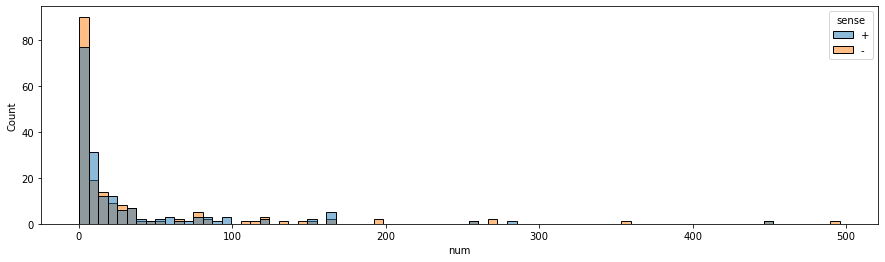

In [27]:
plt.figure(figsize=(15, 4))
sns.histplot(data=real_counts, x='num', hue='sense', bins='auto')

We can see the number of binding sites found on the shuffled genomes:

In [28]:
shuf_counts = enrichment_result['shuf_counts']
shuf_counts.head()

,Matrix_id,sense,id,num
0,126,+,background_seq_1,5
1,126,+,background_seq_10,21
2,126,+,background_seq_100,9
3,126,+,background_seq_101,9
4,126,+,background_seq_102,14


In [29]:
shuf_stats = enrichment_result['shuf_stats']
shuf_stats.head()

,Matrix_id,sense,len,avg,sd
0,126,+,300,13.076667,3.574920
1,126,-,300,11.423333,3.308667
2,131,+,300,173.020000,11.514696
3,131,-,300,80.726667,8.371313
4,1334,+,300,9.150000,2.921635


We can examine the enrichment for each PWM.

In [30]:
enr = enrichment_result['enrichment']
enr.head()

,Matrix_id,sense,num,len,avg,sd,p,fdr
0,M042_0.6,+,4,300,26.466667,6.911448,1.529477e-07,0.000027
1,75,+,452,300,543.363333,32.258228,4.715209e-05,0.004173
2,s26,+,280,300,220.890000,15.070777,1.092412e-04,0.006445
3,s12,+,36,300,19.826667,4.428921,9.729964e-04,0.043055
4,M102_0.6,+,29,300,15.620000,4.014472,2.079840e-03,0.061355


We can separate out the PWMs that are enriched / depleted on each strand:

In [31]:
enr_pos = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='+')].reset_index(drop=True) # enriched on + strand
enr_neg = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='-')].reset_index(drop=True) # enriched on - strand
dep_pos = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='+')].reset_index(drop=True) # depleted on + strand
dep_neg = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='-')].reset_index(drop=True) # depleted on - strand

print(len(enr_pos))
print(len(enr_neg))
print(len(dep_pos))
print(len(dep_neg))

2
2
2
7


We can view the PWMs that are enriched on the `+` strand:

In [32]:
enr_pos

,Matrix_id,sense,num,len,avg,sd,p,fdr
0,s26,+,280,300,220.890000,15.070777,0.000109,0.006445
1,s12,+,36,300,19.826667,4.428921,0.000973,0.043055


And match these to RBPs:

In [33]:
enr_pos = enr_pos.merge(pwms.loc[:,['Matrix_id', 'Gene_name', 'Experiment_description']])
enr_pos.head()

,Matrix_id,sense,num,len,avg,sd,p,fdr,Gene_name,Experiment_description
0,s26,+,280,300,220.890000,15.070777,0.000109,0.006445,SFPQ,SELEX
1,s12,+,36,300,19.826667,4.428921,0.000973,0.043055,PTBP1,SELEX


## Enrichment plot

We can plot the distribution of binding sites for any set of PWMs. Here we plot the distributions for the enriched PWMs:

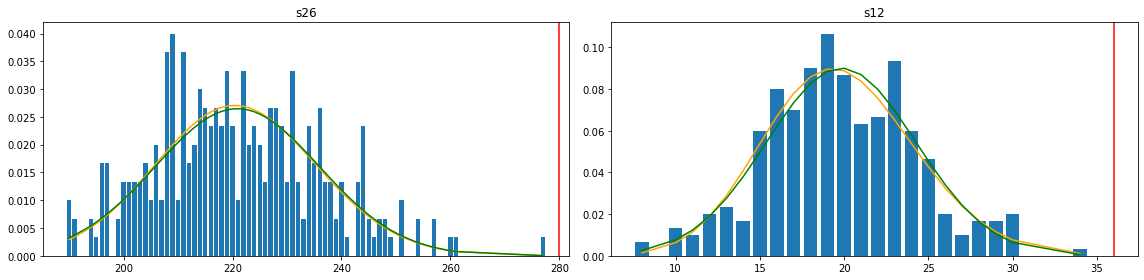

In [34]:
plot_background(shuf_counts[shuf_counts.sense=="+"], real_counts[real_counts.sense=="+"], 
                enr_pos.Matrix_id, genome_len, background='both', figsize=(16,4), ncols=8)

And for the depleted PWMs:

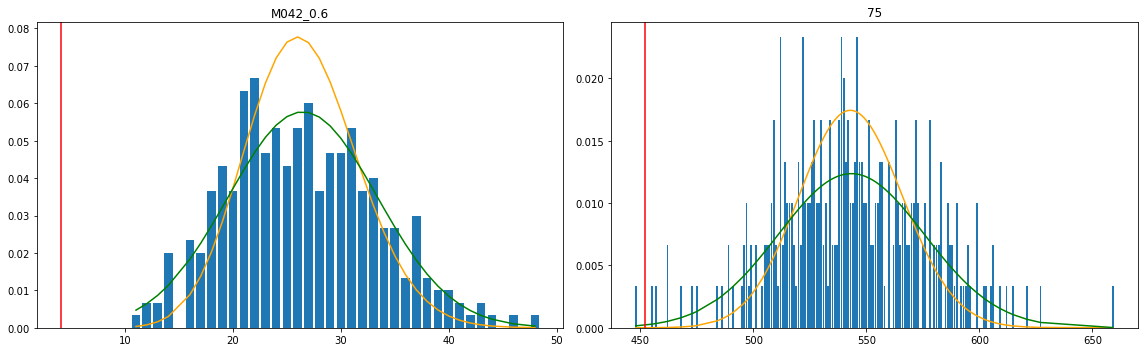

In [35]:
plot_background(shuf_counts[shuf_counts.sense=="+"], real_counts[real_counts.sense=="+"], 
                dep_pos.Matrix_id, genome_len, background='both', figsize=(16,5), ncols=7)

## Enrichment in sliding windows

For any given PWM, we can test for enrichment of its binding sites in sliding windows across the genome using Fisher's exact test. Here we test for enrichment of a specific PWM in the positive ('+') sense genome.

In [65]:
select_sites = real_sites[(real_sites.sense=="+") & (real_sites.Matrix_id=='75')]
select_sites.head()

,id,name,sense,start,Matrix_id,width,end,score,max_score,frac_score
4,NC_002204.1,NC_002204.1,+,25,75,6,31,5.997296,5.997296,1.0
5,NC_002204.1,NC_002204.1,+,26,75,6,32,5.997296,5.997296,1.0
6,NC_002204.1,NC_002204.1,+,27,75,6,33,5.997296,5.997296,1.0
9,NC_002204.1,NC_002204.1,+,28,75,6,34,5.997296,5.997296,1.0
11,NC_002204.1,NC_002204.1,+,36,75,6,42,5.997296,5.997296,1.0


In [66]:
r = enrich_in_sliding_windows(select_sites, genome, 500, 250)

We select significantly enriched bins:

In [68]:
r[(r.padj<0.05) & (r.odds > 1)]

,start,end,count,tot_count,expected,odds,p,id,padj


and significantly depleted bins:

In [69]:
r[(r.padj<0.05) & (r.odds < 1)]

,start,end,count,tot_count,expected,odds,p,id,padj
53,250,750,2,452,15.637974,0.124391,0.000048,NC_002210.1,0.00297
